In [1]:
import pandas as pd

df = pd.read_csv("data/steam_data_with_time.csv", names=["Game", "GameID", "PlayerCount", "time"], header=None)
df[df['PlayerCount'] > 10_000]

,Game,GameID,PlayerCount,time
61156,Lost Ark,1599340,36844.0,20:32:01
91940,Lost Ark,1599340,36825.0,21:45:46
167139,Lost Ark,1599340,31124.0,01:31:32
178903,Lost Ark,1599340,31040.0,02:02:11
292572,Lost Ark,1599340,40172.0,17:57:23
294801,Lost Ark,1599340,40172.0,18:11:31
300613,Lost Ark,1599340,39580.0,18:26:06
305207,Lost Ark,1599340,38387.0,18:43:44
313987,Lost Ark,1599340,37606.0,19:12:49
323675,Lost Ark,1599340,36985.0,19:42:12


<Axes: >

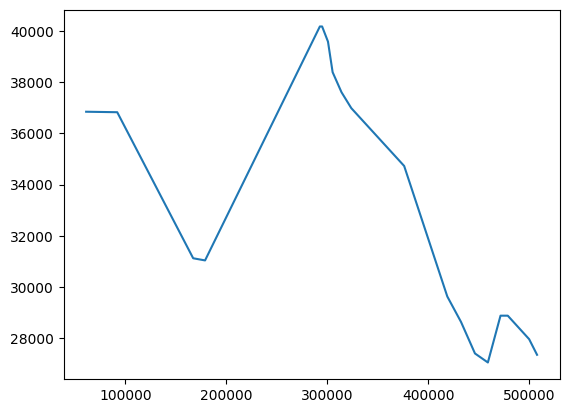

In [2]:
df[df['Game'] == 'Lost Ark']["PlayerCount"].plot()

In [13]:
import requests

def fetch_reviews(app_id):
    url = f"http://store.steampowered.com/appreviews/{app_id}?json=1"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        return None

# Example usage
# reviews = fetch_reviews(2114740)  # Replace 2114740 with the actual GameID
fetch_reviews(782330)

{'success': 1,
 'query_summary': {'num_reviews': 20,
  'review_score': 8,
  'review_score_desc': 'Very Positive',
  'total_positive': 94800,
  'total_negative': 9123,
  'total_reviews': 103923},
 'reviews': [{'recommendationid': '146503855',
   'author': {'steamid': '76561198079979122',
    'num_games_owned': 522,
    'num_reviews': 26,
    'playtime_forever': 3305,
    'playtime_last_two_weeks': 0,
    'playtime_at_review': 3252,
    'last_played': 1695336795},
   'language': 'english',
   'review': 'Pay Mick Gordon',
   'timestamp_created': 1694991259,
   'timestamp_updated': 1694991259,
   'voted_up': True,
   'votes_up': 77,
   'votes_funny': 3,
   'weighted_vote_score': '0.863440513610839844',
   'comment_count': 0,
   'steam_purchase': True,
   'received_for_free': False,
   'written_during_early_access': False,
   'hidden_in_steam_china': True,
   'steam_china_location': ''},
  {'recommendationid': '146756814',
   'author': {'steamid': '76561199242564805',
    'num_games_owned':

Analyze reviews

In [16]:
_ = df[df['PlayerCount'] > 100]
unique_df = _.drop_duplicates(subset=["GameID"])

print(f"Getting reviews for {len(unique_df)} games!")
unique_df["Reviews"] = unique_df['GameID'].apply(fetch_reviews)

Getting reviews for 164 games!


/var/folders/fy/6nhb1jds74vcbb55n83td9ph0000gn/T/ipykernel_25030/2037300744.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_df["Reviews"] = unique_df['GameID'].apply(fetch_reviews)


In [2]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline

model_path = "martin-ha/toxic-comment-model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)


# Toxicity model
toxicity =  TextClassificationPipeline(model=model, tokenizer=tokenizer)

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# Spam detection model
tokenizer = AutoTokenizer.from_pretrained("mrm8488/bert-tiny-finetuned-sms-spam-detection")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/bert-tiny-finetuned-sms-spam-detection")
spmodel = TextClassificationPipeline(model=model, tokenizer=tokenizer)

def spam(x):
    output = spmodel(x)[0]
    
    if "LABEL_0" in output['label']:
        return [{'label': 'spam not detected', 'score': output['score']}]
    elif "LABEL_1" in output['label']:
        return [{'label': 'spam detected', 'score': output['score']}]

In [16]:
# Sentiment detection model
model_path = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
sentmodel = TextClassificationPipeline(model=model, tokenizer=tokenizer)
def sentiment(x):
    output = sentmodel(x)[0]
    
    if "LABEL_0" in output['label']:
        return [{'label': 'bad sentiment', 'score': output['score']}]
    elif "LABEL_1" in output['label']:
        return [{'label': 'neutal sentiment', 'score': output['score']}]
    elif "LABEL_2" in output['label']: # LABEL_2 
        return [{'label': 'good sentiment', 'score': output['score']}]
    
    

In [33]:
# Function that we will re-use

def get_text_analysis(text):
      tox = toxicity(text)
      spm = spam(text)
      sent = sentiment(text)
      
      
      print(f"""
            Toxicity: {tox}
            Spam: {spm}
            Sentiment: {sent}
            """)
      
      return {
            "toxicity": tox,
            'spam': spm,
            'sentiment': sent
      }
      
# Example #1
a1 = "This game slaps harder than my dad's belt"
get_text_analysis(a1)

a2 = """Gameplay is great everything else is trash."""
 
get_text_analysis(a2)

a3 = """
better than cocain
"""
get_text_analysis(a3)




            Toxicity: [{'label': 'non-toxic', 'score': 0.9985877275466919}]
            Spam: [{'label': 'spam not detected', 'score': 0.937032163143158}]
            Sentiment: [{'label': 'bad sentiment', 'score': 0.9000658988952637}]
            

            Toxicity: [{'label': 'toxic', 'score': 0.93875652551651}]
            Spam: [{'label': 'spam not detected', 'score': 0.9355339407920837}]
            Sentiment: [{'label': 'bad sentiment', 'score': 0.5453166961669922}]
            

            Toxicity: [{'label': 'non-toxic', 'score': 0.9938931465148926}]
            Spam: [{'label': 'spam not detected', 'score': 0.9348354935646057}]
            Sentiment: [{'label': 'neutal sentiment', 'score': 0.6315608620643616}]
            


{'toxicity': [{'label': 'non-toxic', 'score': 0.9938931465148926}],
 'spam': [{'label': 'spam not detected', 'score': 0.9348354935646057}],
 'sentiment': [{'label': 'neutal sentiment', 'score': 0.6315608620643616}]}